This notebooks follows Chris McCormick's tutorial on how to fine-tune BERT on IMDB sentiment analysis dataset.

Link : https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification

In [54]:
# installing dependencies
!pip install pytreebank
!pip install seqeval
!pip install transformers
!spacy download en_core_web_sm
!pip install -U imbalanced-learn

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 163kB 3.4MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [0]:
import torch
import pandas as pd
import re

In [12]:
# setting the device

# if GPU is available on this machine
if torch.cuda.is_available():
  device = torch.device('cuda')
  print(f'GPU(s) available : {torch.cuda.device_count()}')
  print(f'Using device : {torch.cuda.get_device_name(0)}')
# if not
else:
  print('No GPU available, using CPU')
  device = torch.device('cpu')

GPU(s) available : 1
Using device : Tesla K80


In [13]:
import pytreebank as ptb
import json
import spacy
import random 
from spacy.util import minibatch, compounding

dataset = ptb.load_sst()
ptb.LabeledTree.inject_visualization_javascript()

In [0]:
def read_tree(sent_dict, l_dict):
  """
  Reads recursively the Treebank and returns a dictionary holding each phrase
  with their polarity / if they have a polarity or not
  """

  # if 'phrase' in sent_dict.keys():
  #   print("Sent dict :", sent_dict['phrase'])

  if 'child0' in sent_dict.keys():
    child0 = sent_dict['child0']
    child1 = sent_dict['child1']

    text0 = child0['text']
    text1 = child1['text']
    
    # setting default next phrase
    child0['phrase'] = child0['text']
    child1['phrase'] = child1['text']

    len_0 = len(text0.split())
    len_1 = len(text1.split())

    if len_0 > 2 and len_1 > 2:
    # if both phrases have more than two tokens    
      child0['phrase'] = child0['text']
      child0['polarity'] = child0['scoreDistr'].index(1.0)

      child1['phrase'] = child1['text']
      child1['polarity'] = child1['scoreDistr'].index(1.0)

      l_dict = read_tree(child0, l_dict)
      l_dict = read_tree(child1, l_dict)

    # continue parsing only one phrase
    elif len_0 <= 2 :
      if 'phrase' not in sent_dict.keys():
        sent_dict['phrase'] = child1['text']
        sent_dict['polarity'] = child1['scoreDistr'].index(1.0)

      # print("Score :", child1['scoreDistr'], child1['rating'], child1['phrase'])

      child1['phrase'] = sent_dict['phrase']
      child1['polarity'] = sent_dict['scoreDistr'].index(1.0)

      l_dict = read_tree(child1, l_dict)

    else:
      if 'phrase' not in sent_dict.keys():
        sent_dict['phrase'] = child0['text']
        sent_dict['polarity'] = child0['scoreDistr'].index(1.0)


      child0['phrase'] = sent_dict['phrase']
      child0['polarity'] = sent_dict['scoreDistr'].index(1.0)

      l_dict = read_tree(child0, l_dict)

  else:
    # reach the leaf of a branch, add the state_dic to the list
    l_dict.append(sent_dict)
  
  return l_dict

In [0]:

dic_polarity = {
    0 : 'Very Bad',
    1 : 'Bad',
    3 : 'Good',
    4 : 'Very Good'
}

def prepare_polarity(parsed_data):
  """
  Returns dictionarry of list, where each element is a tuple
  indicating start, end and type of an NER"
  """
  l_polarity = []

  for data in parsed_data:
    polarity = data['polarity']

    if polarity != 2:
      polarity_label = dic_polarity[polarity]

      if polarity < 2:
        sentiment = 0
        sentiment_label = 'Negative'
      else:
        sentiment = 1
        sentiment_label = 'Positive'

      text = data['phrase']
      l_polarity.append((text, polarity, polarity_label, sentiment, sentiment_label))

  return l_polarity


def prepare_data_polarity(dataset):
  """
  Read the Stanford Treebank dataset and transforms it
  in the format required by spacy for NER training
  """
  data_list = []
  for data in dataset:
    # data are strings in JSON format
    dic_data = json.loads(data.to_json())
    context = dic_data['text']

    # initiate empty list that will hold the parsed data
    # as read_tree() is a recursive functionm parsed_data must
    # be passed as an argument
    parsed_data = []
    parsed_data = read_tree(dic_data, parsed_data)
    
    # only give phrases that are not neutral
    polarity = prepare_polarity(parsed_data)

    # only add data with polarity in it
    if polarity:
      data_list.extend(polarity)

  df = pd.DataFrame.from_records(data_list, columns=['text', 'polarity', 'polarity_label', 'sentiment', 'sentiment_label'])
  return df



In [0]:
from transformers import BertTokenizer
def get_max_seq_length(dataset, tokenizer):

  max_len = 0
  for text in dataset:
    input_ids = tokenizer.encode(text, add_special_tokens = True)
    max_len = max(max_len, len(input_ids))
  print(f"Max sentence length : {max_len}")
  return max_len


In [0]:
# loading and checking data
train = dataset['train'] + dataset['test']
val = dataset['dev']
df = prepare_data_polarity(train)
df_dev = prepare_data_polarity(val)

In [29]:
df.head()

,text,polarity,polarity_label,sentiment,sentiment_label
0,The gorgeously elaborate continuation,3,Good,1,Positive
1,co-writer/director Peter Jackson 's expanded v...,3,Good,1,Positive
2,more simply intrusive,1,Bad,0,Negative
3,the whole package,3,Good,1,Positive
4,with hearts of gold,3,Good,1,Positive


In [27]:
df_dev.head()

,text,polarity,polarity_label,sentiment,sentiment_label
0,a lovely film,4,Very Good,1,Positive
1,"unindicted here ,",1,Bad,0,Negative
2,which is probably for the best,4,Very Good,1,Positive
3,"A warm , funny",4,Very Good,1,Positive
4,", engaging film .",3,Good,1,Positive


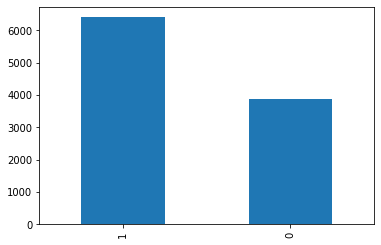

In [30]:
# data is balanced
df.sentiment.value_counts().plot(kind = 'bar')

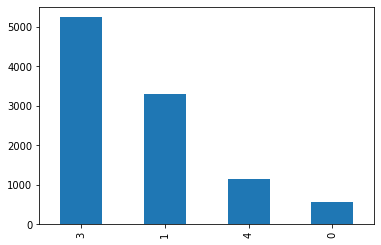

In [31]:
df.polarity.value_counts().plot(kind = 'bar')

In [51]:
def get_num_label(df, column):
  return len(df[column].unique())
num_labels = get_num_label(df, 'sentiment')
print(num_labels)

2


In [0]:
# defining BERT model type for tokenizer and pretrained_model
model_name = 'bert-base-cased'
if 'uncased' in model_name:
  do_lower_case = True
else:
  do_lower_case = False

In [34]:
# loading BertTokenizer
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case = do_lower_case)

In [0]:
data_text = df.text.values
data_binary_target = df.sentiment.values
data_multi_target = df.polarity.values

In [58]:
data_text.shape

(10286,)

In [0]:
# oversampling data
from imblearn.over_sampling import SMOTE, RandomOverSampler
ros = RandomOverSampler(random_state = 0)
X_resampled, y_resampled = ros.fit_sample(data_text.reshape(-1, 1), data_binary_target)
X_resampled = X_resampled.flatten()

In [64]:
X_resampled.shape

(12802,)

In [37]:
get_max_seq_length(data_text, tokenizer)

Max sentence length : 31


31

In [0]:
MAX_LEN = 32

In [0]:
def data_to_bert_format(dataset, labels, max_len = 512):

  # BERT needs input data as tokens ids
  input_ids = []
  attention_masks = []
  for data in dataset:
    encoded_dict = tokenizer.encode_plus(
        data,
        add_special_tokens = True,
        max_length = max_len,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

  input_ids = torch.cat(input_ids, dim = 0)
  attention_masks = torch.cat(attention_masks, dim = 0)
  labels = torch.tensor(labels)
  return input_ids, attention_masks, labels

In [0]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

def dataset_to_pytorch(dataset, labels, max_len=512, split=.9, batch_size = 32):

  input_ids, attention_masks, labels = data_to_bert_format(dataset, labels, max_len)

  # combining inputs into dataset
  dataset = TensorDataset(input_ids, attention_masks, labels)

  # defining train and validation sets
  train_size = int(split * len(dataset))
  val_size = len(dataset) - train_size

  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

  print(f"Train size : {train_size}")
  print(f"Validation size : {val_size}")
  # creating Dataloader

  train_dataloader = DataLoader(
      train_dataset, # training samples
      sampler = RandomSampler(train_dataset), # select data randomly
      batch_size = batch_size
  )

  val_dataloader = DataLoader(
      val_dataset,
      sampler = SequentialSampler(val_dataset), # select data sequentially
      batch_size = batch_size
  ) 
  return train_dataloader, val_dataloader

In [65]:
# BINARY CLASSIFICATION DATASET
train_dataloader, val_dataloader = dataset_to_pytorch(X_resampled, y_resampled, MAX_LEN)

Train size : 11521
Validation size : 1281


In [53]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
# loading BertForSequenceClassifcation, with linear layer on top

def load_bert_for_classification(model_name, num_labels):

  model = BertForSequenceClassification.from_pretrained(
      model_name,
      num_labels = num_labels,
      output_attentions = False,
      output_hidden_states = False
  )
  model.to(device)
  return model

model = load_bert_for_classification(model_name, num_labels)

In [0]:
from transformers import get_linear_schedule_with_warmup
# hyperparameters
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8)

# number of epochs and total number of training steps
epochs = 5
total_steps = len(train_dataloader) * epochs

# creates the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

In [0]:
import numpy as np
import time
import datetime

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
# training function
def train(model, data_loader, optimizer,
          device, scheduler, n_examples, max_norm = 1.0):
  model = model.train()

  total_eval_loss = 0

  for batch in data_loader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    target = batch[2].to(device)

    # clearing accumulated gradients
    model.zero_grad()

    loss, logits = model(input_ids = input_ids,
                   attention_mask = attention_mask,
                   token_type_ids = None,
                   labels=target)
    
    total_eval_loss += loss.item()

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
    
    optimizer.step()
    scheduler.step()

  return total_eval_loss / n_examples

In [0]:
# training and evaluation
import random
import numpy as np
# set the seed to make the results reproducible
seed_val = 42
random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# stats : training and validation loss, timing
training_stats = []

total_time = time.time()

for epoch in range(0, epochs):
  print(f"=== Epoch {epoch + 1} / {epochs}")
  print("Training :")
  # measures epoch time
  t0 = time.time()
  # total loss for this epoch
  total_train_loss = 0

  # ==== Training ====

  # put model into training mode 
  model.train()

  for step, batch in enumerate(train_dataloader):
    # display progress update every 50 batch
    if step % 50 == 0 and not step == 0:
      # calculated elapsed time since epoch beginning
      elapsed = format_time(time.time() - t0)
      print(f"{step} steps over {len(train_dataloader)} in {elapsed}")

      # putting batch data into GPU or CPU
      input_ids = batch[0].to(device)
      attention_mask = batch[1].to(device)
      target = batch[2].to(device)

      # clearing accumulated gradients
      model.zero_grad()

      loss, logits = model(input_ids = input_ids,
                    attention_mask = attention_mask,
                    token_type_ids = None,
                    labels=target)
      
      total_eval_loss += loss.item()

      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
      
      optimizer.step()
      scheduler.step()
  
  # calculate average train loss 
  avg_train_loss = total_train_loss / len(train_dataloader)
  # calculate overall training time
  training_time = format_time(time.time() - t0)

  print("=" * 10)
  print(f'Average training loss : {avg_train_loss}')
  print(f'Epoch training time : {training_time}')
  print("=" * 10)

  # ===== Validation ======
  print("Running validation ...")
  t0 = time.time()
  # set model to eval mode
  model.eval()

  # tracking variables
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  # evaluation on this epoch
  for batch in val_dataloader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    target = batch[2].to(device)

    with torch.no_grad():
     
      loss, logits = model(input_ids = input_ids,
                   attention_mask = attention_mask,
                   token_type_ids = None,
                   labels=target)
    
    # calculating loss and accuracy
    total_eval_loss += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = target.to('cpu').numpy()

    total_eval_accuracy += flat_accuracy(logits, label_ids)
  
  # final accuracy for this run 
  avg_val_accuracy = total_eval_accuracy / n_examples
  avg_val_loss = total_eval_loss / n_examples
  validation_time = format_time(time.time() - t0)

  print(f'Validation accuracy {avg_val_accuracy}')
  print(f'Validation loss {avg_val_loss}')
  print(f'Time : {validation_time}')

  # recording stats on this epoch
  training_stats.append(
      {
        'epoch' : epoch + 1,
       'training_loss' : avg_train_loss,
       'valid_loss' : avg_val_loss,
       'val_accuracy' : avg_val_accuracy,
       'training_time' : training_time,
       'validation_time' : validation_time
      }
  )

print('=' * 10)
print('Training complete !')
print(f'Total training time : {format_time(time.time() - total_time)}')


=== Epoch 1 / 5
Training :
50 steps over 1407 in 0:00:00


RuntimeError: ignored